# EmbedRank Analysis

## Step 1: Loading the data

In [1]:
import spacy

In [67]:
import numpy as np

In [11]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
nlp = spacy.load('en_core_web_sm')

C:\Users\nishu\Anaconda3\envs\mnist\lib\site-packages\spacy\util.py:732: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.1.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [15]:
abstract = u"A molecular equivalence number (meqnum) classifies a molecule with respect to a class of structural features or topological shapes such as its cyclic system or its set of functional groups. Meqnums can be used to organize molecular structures into nonoverlapping, yet highly relatable classes. We illustrate the construction of some different types of meqnums and present via examples some methods of comparing diverse chemical libraries based on meqnums. In the examples we compare a library which is a random sample from the MDL Drug Data Report (MDDR) with a library which is a random sample from the Available Chemical Directory (ACD). In our analyses, we discover some interesting features of the topological shape of a molecule and its set of functional groups that are strongly linked with compounds occurring in the MDDR but not in the ACD. We also illustrate the utility of molecular equivalence indices in delineating the structural domain over which an SAR conclusion is valid."

## Step 2: Extracting Key Phrases

In [16]:
doc = nlp(abstract)

In [25]:
pos = [doc[word].pos_ for word in range(len(doc))]

In [106]:
tokens_cpy = []

itr = len(pos) - 1
while itr >= 0:
    if pos[itr] == "NOUN":
        curr_tokens = [doc[itr].text]
        itr -= 1
        while itr >= 0 and pos[itr] == "ADJ":
            curr_tokens.insert(0, doc[itr].text)
            itr -= 1
        tokens_cpy.append(curr_tokens)
    else:
        itr -= 1
        
tokens = []
[tokens.append(x) for x in tokens_cpy if x not in tokens]
tokens

[['conclusion'],
 ['structural', 'domain'],
 ['molecular', 'equivalence'],
 ['utility'],
 ['compounds'],
 ['functional', 'groups'],
 ['set'],
 ['molecule'],
 ['topological', 'shape'],
 ['interesting', 'features'],
 ['analyses'],
 ['random', 'sample'],
 ['library'],
 ['examples'],
 ['meqnums'],
 ['libraries'],
 ['diverse', 'chemical'],
 ['methods'],
 ['different', 'types'],
 ['construction'],
 ['relatable', 'classes'],
 ['nonoverlapping'],
 ['molecular', 'structures'],
 ['cyclic', 'system'],
 ['topological', 'shapes'],
 ['structural', 'features'],
 ['class'],
 ['respect'],
 ['meqnum'],
 ['number']]

## Step 3: Embedding the Tokens

In [50]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [51]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

C:\Users\nishu\Anaconda3\envs\mnist\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [107]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [108]:
token_vecs = [model.infer_vector(token) for token in tokens]

## Step 4: Embedding the Document

In [109]:
cleaned_indexes = np.bitwise_or(np.array(pos) == "NOUN", np.array(pos) == "ADJ")

In [110]:
words = [doc[word].text for word in range(len(doc))]
cleaned_text = (np.array(words)[cleaned_indexes])

In [111]:
doc_vec = model.infer_vector(cleaned_text)

## Step 5: Calculating Cosine Distance + Selecting Tokens

In [86]:
from scipy import spatial

In [173]:
cosine_distances = np.array([spatial.distance.cosine(doc_vec, vec) for vec in token_vecs])

In [121]:
top_indexes = cosine_distances.argsort()[-10:][::-1]
selected_tokens_cpy = np.array(tokens)[top_indexes]
selected_tokens = [" ".join(token) for token in selected_tokens_cpy]

C:\Users\nishu\Anaconda3\envs\mnist\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [122]:
selected_tokens

['respect',
 'libraries',
 'molecular structures',
 'random sample',
 'analyses',
 'structural domain',
 'methods',
 'relatable classes',
 'molecule',
 'compounds']

## Step 6: Creating the Wordcloud

In [125]:
pip install wordcloud -q

Note: you may need to restart the kernel to use updated packages.


In [130]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

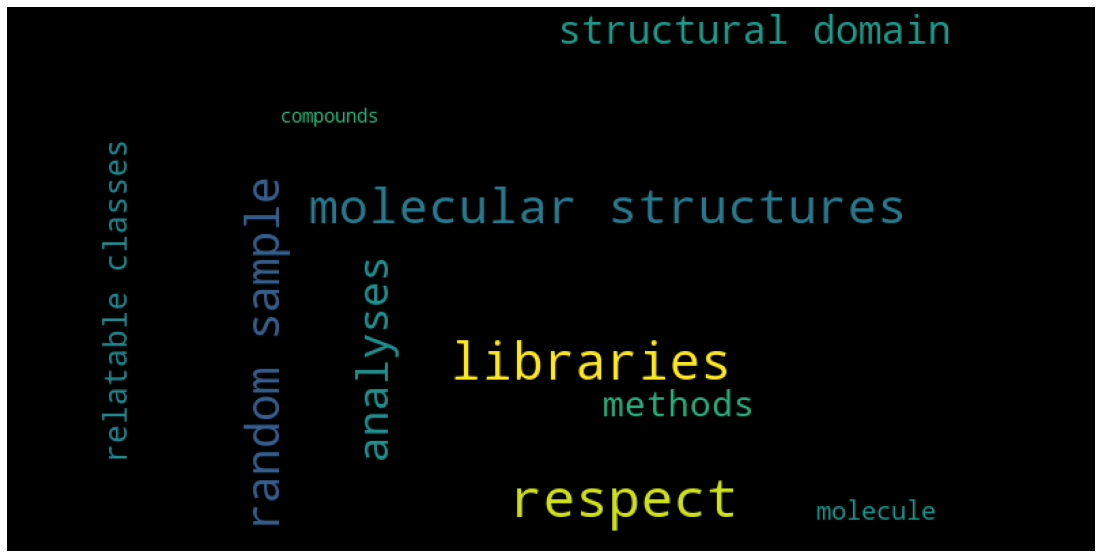

In [176]:
wordcloud_text = ""
wordcloud_dict = dict()

for itr in range(len(selected_tokens)):
    token = selected_tokens[itr]
    wordcloud_dict[token] = 2 * (len(selected_tokens) - itr)     
    
wordcloud = WordCloud(max_font_size = 40, max_words = 10, background_color = "black", width = 800, height = 400, collocations=False).generate_from_frequencies(wordcloud_dict)

  
plt.figure(figsize = (20,10))
plt.axis("off")

plt.imshow(wordcloud)

## Step 7: Methodology Analysis

Question: Summarizing a document with some keywords can give a concise yet interpretable representation of a paper. However, EmbedRank exploits only the keywords that are contained in a document to summarize it. This can miss useful keywords. Do you agree? How can we address this limitation?

**I agree that this could miss some useful keywords. One way to address this is to expand what we consider to be a keyword. Maybe we can take the existing keywords and generate new keywords using a similar approach with cosine similarity and a dictionary lookup system. Also, there might be some creative ways to find our missed keywords by performing some sort of regression or average of our top n keywords to generate new keywords (with the reversal of our embedding process)**